In [1]:
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
import holidays

import matplotlib.pyplot as plt

import sys
sys.path.append("../")
import asset.MyPlot as mp
import asset.DataSupply as ds

import warnings
warnings.filterwarnings("ignore")

## start ====data generating

In [4]:
# df_rain_historical, dct_areas = ds.GetRainfallByPumps(
#     ["oude_engelenseweg"]
# )

# df_dry = GenerateMLdata(
#     "oude_engelenseweg",
#     3.5645260088514346,
#     0.0,
#     df_rain_historical,
#     dct_areas
# )

df_dry = pd.read_csv(
    "../asset/data/model_data_oude_engelenseweg.csv", index_col=0, parse_dates=True
)

In [5]:
df_dry

,oude_engelenseweg_in_flow_vol,oude_engelenseweg_flow_value,oude_engelenseweg_level_value,oude_engelenseweg_last_in_flow_vol,oude_engelenseweg_vol_remain
end_hour,,,,,
2019-09-01 19:00:00,426.794957,613.720167,224.533,NaN,800.353718
2019-09-01 20:00:00,673.460157,681.009167,221.067,426.794957,787.999071
2019-09-01 21:00:00,409.207586,492.535833,246.933,673.460157,880.199101
2019-09-03 04:00:00,198.665293,175.769667,231.067,409.207586,823.644331
2019-09-03 05:00:00,65.587279,202.584333,246.667,198.665293,879.250937
...,...,...,...,...,...
2020-07-31 19:00:00,413.485017,724.799500,206.000,470.517433,734.292358
2020-07-31 20:00:00,667.279269,520.225833,245.600,413.485017,875.447588
2020-07-31 21:00:00,698.173016,830.335333,212.267,667.279269,756.631242


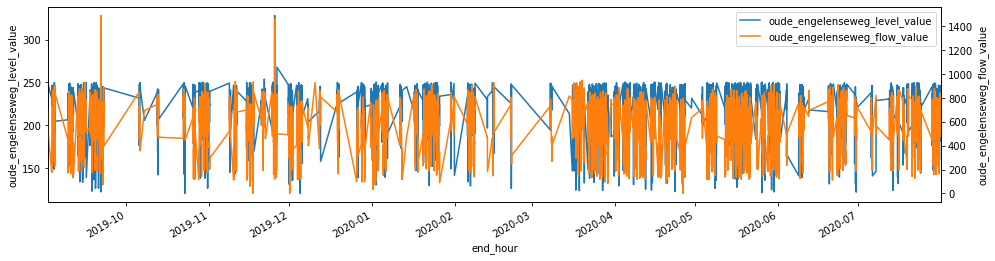

In [7]:
mp.PlotMulti(df_dry[["oude_engelenseweg_level_value", "oude_engelenseweg_flow_value"]], figsize=(16, 4))

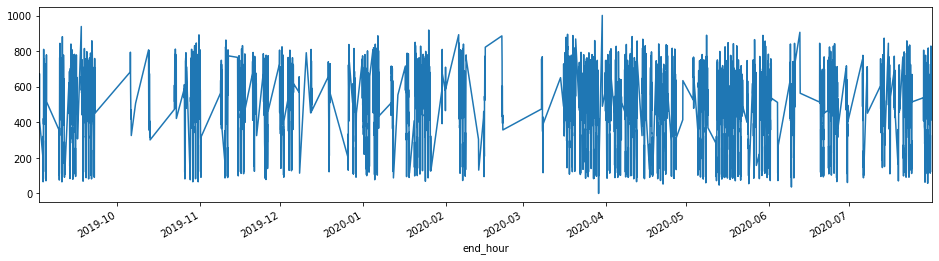

In [8]:
df_grouped = df_dry.groupby("end_hour", as_index=True).sum()[["oude_engelenseweg_in_flow_vol", "oude_engelenseweg_flow_value"]]
df_grouped["oude_engelenseweg_in_flow_vol"].plot(figsize=(16, 4))

In [9]:
nl_holidays = holidays.NL()

df_grouped["hour"] = df_grouped.index.hour
df_grouped["day"] = df_grouped.index.day
df_grouped["weekday"] = df_grouped.index.weekday
df_grouped["month"] = df_grouped.index.month
df_grouped["year"] = df_grouped.index.year
df_grouped["is_holiday"] = [int(i.date() in nl_holidays) for i in df_grouped.index]
df_grouped["oude_engelenseweg_last_in_flow_vol"] = df_grouped["oude_engelenseweg_in_flow_vol"].shift()
df_grouped["covid"] = df_grouped.index > "2020-03-15 00:00:00"

In [10]:
# estimators
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import xgboost as xgb
from sklearn.linear_model import ElasticNet

# evaluators
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [11]:
seed = 666

data = df_grouped.copy()
X = data.iloc[1:, 2:]
y = data.iloc[1:, 0]

best_sfs = None
best_nmae = float("-inf")
for i in range(1, 8):
    sfs_temp = SFS(
        RandomForestRegressor(random_state=seed),
        k_features=i,
        forward=True,
        floating=False,
        scoring="neg_mean_absolute_error",
        cv=0,
    )
    sfs_temp.fit(X, y)
    print(f"""{i} features, with neg_mean_absolute_error: {sfs_temp.k_score_}""")
    if sfs_temp.k_score_ > best_nmae:
        best_sfs = sfs_temp
        best_nmae = sfs_temp.k_score_


print(f"best: {best_sfs.k_feature_names_}")
X_new = best_sfs.transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2, random_state=seed
)

1 features, with neg_mean_absolute_error: -80.53012602407665
2 features, with neg_mean_absolute_error: -40.10669167773293
3 features, with neg_mean_absolute_error: -36.35269214806048
4 features, with neg_mean_absolute_error: -34.584541565085175
5 features, with neg_mean_absolute_error: -34.285977083789746
6 features, with neg_mean_absolute_error: -34.26035951868236
7 features, with neg_mean_absolute_error: -34.180802579736
best: ('hour', 'day', 'weekday', 'month', 'year', 'is_holiday', 'oude_engelenseweg_last_in_flow_vol')


In [12]:
# params for rf
min_samples_split = [
    10, 20,30
]
min_samples_leaf = [
    1, 2, 4, 6
]

# params for xgb
subsample = [
    0.5, 0.8, 1
]
objective = ["reg:squarederror", "reg:pseudohubererror"]
gamma = [
    0,1,5
]

# params for en
max_iter = [1, 5, 10]
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
l1_ratio = np.arange(0.0, 1.0, 0.1)

# params for rf & xgb
n_estimators = [int(x) for x in np.linspace(start=50, stop=150, num=5)]
max_depth = [int(x) for x in np.linspace(5, 25, num=5)]
max_depth.append(None)


names = [
    "RandomForestRegressor",
    "XGBRegressor",
    "ElasticNet",
]

estimators = [RandomForestRegressor(), xgb.XGBRegressor(), ElasticNet()]

param_rfr = {
    "bootstrap": [True],
    "max_features": ["auto"],
    "random_state": [seed],
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
}

param_xgbr = {
    "eval_metric": ["mae"],
    "booster": ["gbtree"],
    "learning_rate": [0.1],
    "min_child_weight": [1],
    "gamma": gamma,
    "nthread": [4],
    "scale_pos_weight": [1],
    "colsample_bytree": [0.3],
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "subsample": subsample,
    "objective": objective,
}

param_en = {"max_iter": max_iter, "alpha": alpha, "l1_ratio": l1_ratio}

parameters = [param_rfr, param_xgbr, param_en]

In [13]:
def gird_search_model(reg, param, name, X_train, y_train, X_test, y_test):
    model = GridSearchCV(
        reg,
        param,
        cv=3,
        verbose=2,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        return_train_score=True,
    )
    fit = model.fit(X_train, y_train)
    y_test_pred = fit.best_estimator_.predict(X_test)
    mae = mean_absolute_error(y_test_pred, y_test)

    cv_results = pd.DataFrame(fit.cv_results_).set_index(["params"])

    print("MODEL : %r" % name)
    print("Best MAE: %f using %s" % (mae, fit.best_params_))

    return cv_results, mae, fit

In [14]:
best_estimators = dict()
score = []
cv_list = []
for clf, param, name in zip(estimators, parameters, names):

    (cv_result, mae, fit) = gird_search_model(
        clf, param, name, X_train, y_train, X_test, y_test
    )
    cv_list.append(cv_result)
    best_estimators[name] = fit
    score.append(mae)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  1.4min finished


MODEL : 'RandomForestRegressor'
Best MAE: 84.710740 using {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 125, 'random_state': 666}
Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 283 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 689 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 1255 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 1613 out of 1620 | elapsed:  1.0min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  1.0min finished


MODEL : 'XGBRegressor'
Best MAE: 92.168593 using {'booster': 'gbtree', 'colsample_bytree': 0.3, 'eval_metric': 'mae', 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 150, 'nthread': 4, 'objective': 'reg:squarederror', 'scale_pos_weight': 1, 'subsample': 0.8}
Fitting 3 folds for each of 210 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.5s finished


MODEL : 'ElasticNet'
Best MAE: 132.364060 using {'alpha': 0.01, 'l1_ratio': 0.0, 'max_iter': 5}


In [15]:
theBest = best_estimators["RandomForestRegressor"].best_estimator_
y_predicted = theBest.predict(X_new)

In [16]:
mean_absolute_error(y_predicted, y)

65.44565823446763

In [17]:
y.describe()

count    3036.000000
mean      483.378734
std       198.196675
min         0.000000
25%       356.930247
50%       479.072296
75%       648.273216
max      1000.448386
Name: oude_engelenseweg_in_flow_vol, dtype: float64

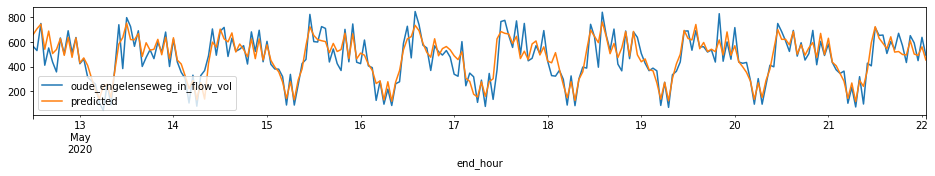

In [18]:
ddd = y.to_frame()
ddd["predicted"] = y_predicted
ddd["2020-05-12 12:00:00":"2020-05-23 12:00:00"].plot(figsize=(16, 2))

In [20]:
np.sum(df_dry["oude_engelenseweg_in_flow_vol"]), np.sum(df_dry["oude_engelenseweg_flow_value"])



(1467964.6315934225, 1669477.0095000002)

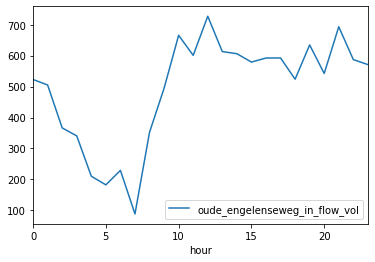

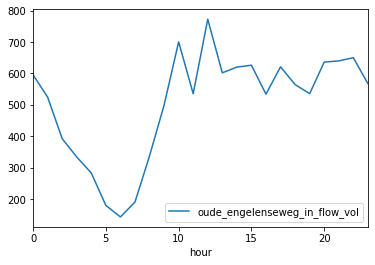

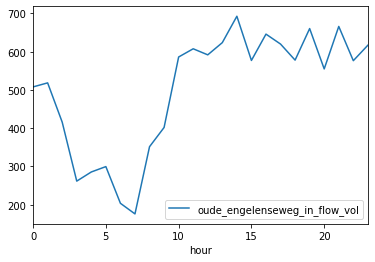

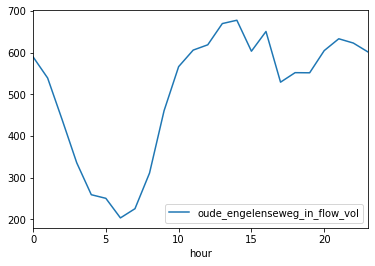

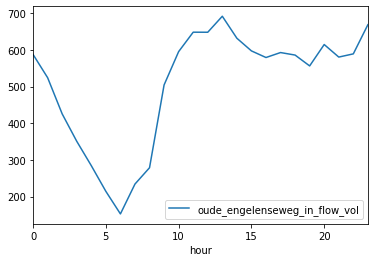

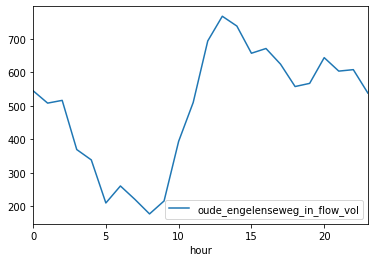

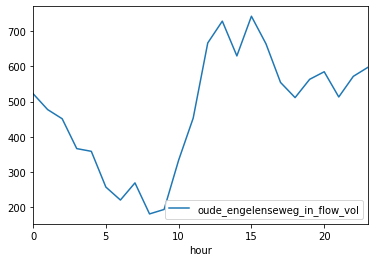

In [21]:
df = df_grouped[:"2020-03-01 00:00:00"][["oude_engelenseweg_in_flow_vol", "hour", "weekday"]].copy()
ss = df.groupby(["weekday", "hour"]).mean()
for i in range(7):
    ss.loc[i].plot()

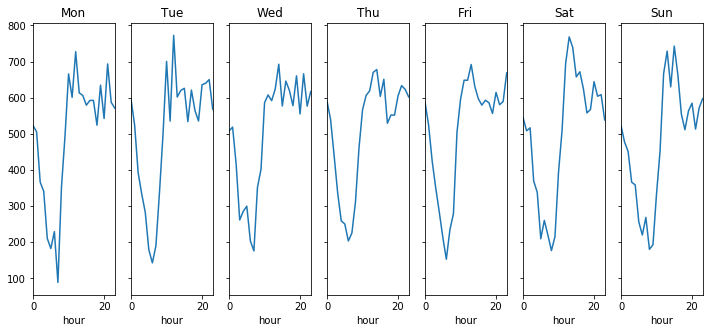

In [22]:
fig, ((ax0, ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(
    nrows=1, ncols=7, sharey=True, figsize=(12, 5)
)

ss.loc[0].plot(ax=ax0).set_title("Mon")
ss.loc[1].plot(ax=ax1).set_title("Tue")
ss.loc[2].plot(ax=ax2).set_title("Wed")
ss.loc[3].plot(ax=ax3).set_title("Thu")
ss.loc[4].plot(ax=ax4).set_title("Fri")
ss.loc[5].plot(ax=ax5).set_title("Sat")
ss.loc[6].plot(ax=ax6).set_title("Sun")
ax0.get_legend().remove()
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()
ax6.get_legend().remove()